# Project For P2 - Introduction To Data Analysis

## Introduction
This project seeks to analyse [Lahman’s Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/) from 1871 to 2015. I am going to analyse theplayer/manager awards and their respective salaries and try to understand their relationship.


## The data set

In seanlahman.com serveral options for accquiring the data set are given(access, CSV and sql), for this project it was chosen the CSV files since they can be easily imported with the [pandas](http://pandas.pydata.org/) library.

The data set comes in a zip bundle that contains several CSV files(referred also as tables throught the rest of this project). Each table relates to a set of statistics about pitching, hitting, and fielding statistics for american baseball games from 1871 through 2015. The layout of the contents of CSV files(the order of the columns) and the detailed description of each column can be found in the [dataset readme](http://seanlahman.com/files/database/readme2014.txt).


## Step One - Choose Your Data Set
Choose one of the following datasets to analyze for your project:

* Titanic Data - Contains demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. You can view a description of this dataset on the Kaggle website, where the data was obtained.
* Baseball Data - A data set containing complete batting and pitching statistics from 1871 to 2014, plus fielding statistics, standings, team stats, managerial records, post-season data, and more. This dataset contains many files, but you can choose to analyze only the one(s) you are most interested in.

_Choose the comma-delimited version, which contains CSV files._
**#todo remove**

## Step Two - Get Organized
Eventually you’ll want to submit your project (and share it with friends, family, and employers). Get organized before you begin. We recommend creating a single folder that will eventually contain:

* The report communicating your findings
* Any Python code you wrote as part of your analysis
* The data set you used (which you will not need to submit)
* You may wish to use IPython notebook, in which case you can submit both the code you wrote and the report of your findings in the same document. Otherwise, you will need to submit your report and code separately.

**remove**

## Step Three - Analyze Your Data
Brainstorm some questions you could answer using the data set you chose, then start answering those questions. Here are some ideas to get you started:

### Titanic Data
* What factors made people more likely to survive?

### Baseball Data
* What is the relationship between different performance metrics? Do any have a strong negative or positive relationship?
What are the characteristics of baseball players with the highest salaries?


Try and suggest questions that promote looking at relationships between multiple variables. You should aim to analyze at least one dependent variable and three independent variables in your investigation.

_Make sure you use NumPy and Pandas where they are appropriate!_



For this project I'm going to analyse the relationship between player salary and player income.

1. Do salaries increase when a player receives an award?
2. Do salaries increase before a player receives an award?
3. Do salaries keep increasing the more awards a player gets?
4. By how much does a salary is expected to increase after an award?
5. Do players that receive awards tend to play in the same teams?
6. Is there an award winning player creep in teams?(Are some teams collecting award winning players and not hiring other players)?



### Before analyzing I must first import some libraries

In [1]:
import pandas as pd, zipfile, os.path, numpy as np#, humanize
%matplotlib inline
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

### And extract the data from the zip file and put it in some variables

In [2]:
salaries_table = pd.read_csv('csvs/Salaries.csv')
awards_table = pd.read_csv('csvs/AwardsPlayers.csv')

### Next I want to get a look at the data

In [3]:
salaries_table.head()

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000


In [4]:
ksalary = salaries_table['salary']/1000
ksalary.describe().apply(np.int64)

count    25575
mean      2008
std       3315
min          0
25%        275
50%        550
75%       2250
max      33000
Name: salary, dtype: int64

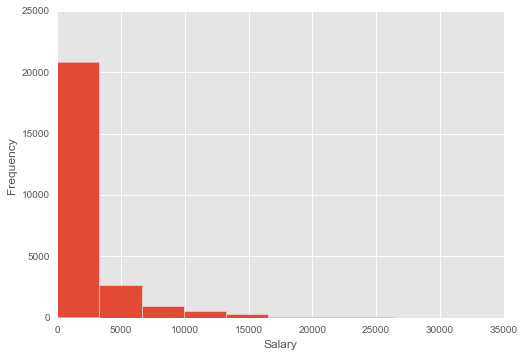

In [5]:
plt.figure()
axes = (ksalary).hist()
axes.set_xlabel("Salary")
axes.set_ylabel("Frequency")

In [6]:
awards_table.head()

,playerID,awardID,yearID,lgID,tie,notes
0,bondto01,Pitching Triple Crown,1877,NL,NaN,NaN
1,hinespa01,Triple Crown,1878,NL,NaN,NaN
2,heckegu01,Pitching Triple Crown,1884,AA,NaN,NaN
3,radboch01,Pitching Triple Crown,1884,NL,NaN,NaN
4,oneilti01,Triple Crown,1887,AA,NaN,NaN


In [7]:
salaries_table.groupby('playerID').count().head()

,yearID,teamID,lgID,salary
playerID,,,,
aardsda01,7,7,7,7
aasedo01,4,4,4,4
abadan01,1,1,1,1
abadfe01,4,4,4,4
abbotje01,4,4,4,4


Now that I'm familiar with the data I can start analyzing

1. Do salaries increase when a player receives an award?

In order to do that I'm going grab the day that a player received his first award and use that to know the average salary before and after the award.

Now before diving into that, is the set of pairs (yearID, playerID) in awards a subset of the set of pairs of (yearID, playerID) in salaries?

In [8]:
from pandas import DataFrame

# There are some duplcates in the salary table, I should take care of that later
salaries_table.count() - salaries_table.drop_duplicates(['playerID', 'yearID']).count()

salaries_table[['playerID', 'yearID']].drop_duplicates().count()

def df_to_set(df):
    return {(tuple(l) if type(l) is list else l) for l in df.values.tolist()}

def set_to_df(set_, columns):
    return DataFrame(list(set_), columns=columns)

def set_subtraction(df1, df2):
    ds1 = df_to_set(df1)
    ds2 = df_to_set(df2)
    subtracted_set = ds2 - ds1
    return set_to_df(subtracted_set, list(df1))

# Ok, we shouldn't expect our resulting table to be as big as the awards table,
# because in some years a player received an award but did not register in the salaries table
subtracted = set_subtraction(salaries_table[['playerID', 'yearID']], awards_table[['playerID', 'yearID']])
print subtracted.count()
subtracted = set_subtraction(awards_table[['playerID', 'yearID']], salaries_table[['playerID', 'yearID']])
print subtracted.count()

playerID    2242
yearID      2242
dtype: int64
playerID    24097
yearID      24097
dtype: int64


So, we can start making the query that we initially set out to make, but before doing that, it's usefult to break it down into steps:

1. Retrieve a list of players that got an award.
2. Retreive a list of years that each player got their first award.
3. Extract a list of salaries before the year of their first award, calculate the mean of those salaries.
4. Extract a list of salaries after the year of their first award, calculate the mean of those salaries.
5. Calculate the average between the differences in salaries.
6. Do the salaries grow?
7. If it exists, is the growth attributable to the award?
8. Explore further.

### Retrieve a list of players that got an award.

In [9]:
playersfromawards = df_to_set(awards_table['playerID'])
playersfromsalaries = df_to_set(salaries_table['playerID'])
awardwinningplayers = set_to_df(playersfromawards.intersection(playersfromsalaries), ['playerID'])
print len(playersfromawards), len(playersfromsalaries), len(awardwinningplayers)
print awardwinningplayers.head()


1323 4963 658
    playerID
0  hrbekke01
1  fostege01
2  hollaal01
3  aurilri01
4  anderga01


### Retreive a list of awards that each player got.

In [10]:
awardsyears = awards_table[['playerID', 'yearID']]
print awardsyears[awardsyears.playerID == 'abreubo01']
awardsyears = awardsyears.merge(awardwinningplayers, on=['playerID'])
print awardsyears.head()
awardsyears = awardsyears.groupby('playerID', as_index=False).first()
print awardsyears.head()

       playerID  yearID
5333  abreubo01    2004
5384  abreubo01    2005
    playerID  yearID
0  ayalabo01    1954
1   rosepe01    1963
2   rosepe01    1965
3   rosepe01    1966
4   rosepe01    1968
    playerID  yearID
0  abbotji01    1991
1  abreubo01    2004
2  abreujo02    2014
3  alfonan01    2000
4  alfoned01    1999


### Extract a list of salaries before the year of their first award, calculate the mean of those salaries.

In [11]:
awardsyears = awardsyears.rename(index=str, columns={"yearID": "firstAward"})

merged = awardsyears.merge(salaries_table, on='playerID')
grouped = merged.groupby('playerID')

def mean_before_first_award(df):
    return df[df.yearID < df.firstAward]['salary'].mean()

means_before = grouped.aggregate(mean_before_first_award)['salary']

print 'Mean before'
print means_before.head()

# We can see that the average before for the playerid abreujo02 is NaN. Is this result correct?

print grouped.get_group('abreujo02')

# Since there was no salary record before 2014 there was nothing to average on

# Lets also get the average for salaries that come after the award

def mean_after_first_award(df):
    return df[df.yearID > df.firstAward]['salary'].mean()

means_after = grouped.aggregate(mean_after_first_award)['salary']

print 'Mean after'
print means_after.head()

#Now lets get the differences between the means

mean_differences = means_after - means_before
print 'Mean differences'
print mean_differences.head()

Mean before
playerID
abbotji01    1.265000e+05
abreubo01    3.439952e+06
abreujo02             NaN
alfonan01    1.916667e+05
alfoned01    5.635000e+05
Name: salary, dtype: float64
     playerID  firstAward  yearID teamID lgID   salary
25  abreujo02        2014    2014    CHA   AL  7000000
26  abreujo02        2014    2015    CHA   AL  8666000
Mean after
playerID
abbotji01    2.058333e+06
abreubo01    1.121250e+07
abreujo02    8.666000e+06
alfonan01    2.111429e+06
alfoned01    6.025000e+06
Name: salary, dtype: float64
Mean differences
playerID
abbotji01    1.931833e+06
abreubo01    7.772548e+06
abreujo02             NaN
alfonan01    1.919762e+06
alfoned01    5.461500e+06
Name: salary, dtype: float64


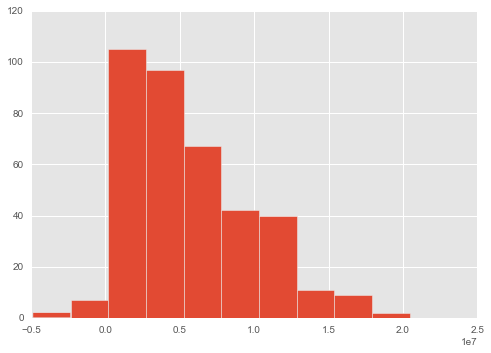

In [12]:
mean_differences.hist()

From the plot, we can see that very few players had a salary decrease after winning a prize and most frequently, players got the most modest increase in their salaries.

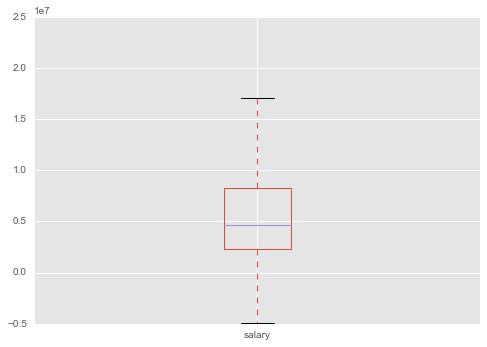

In [13]:
mean_differences.plot.box()

This chart gives us a much clearer view of where most of the differences are.

Now we want to know how much is that distrbution different from the differences of salaries between two points. In other words a control group.

## Calculating the significance

In the previous calculations we wanted to know if players that receive an award end up getting bigger salaries in their careers. We identified that indeed, most players end up receiving more than they received before the award. But, is that result significant? Isn't there the possibility that a player will end up receiving more as their careers advances? We need to have a control group to compare with our previous results.

It seems reasonable that we should use the control group as players that did not receive any awards. But what time period should I take, in other words what's the moment in the player career that I should take to get the average salary above or below? Lets list the possible problems:

* If I take a time period that's too early in the player career the player may have not been able to show its potential and thus its salary may have not started to creep up.
* If we take moment that is too late the salary gains may be influenced by the aging of the player.
* Finally if we choose that we should compare the salary from the middle of the career there is also the risk that the player salary is so high that the salary differences need to be much greater than on the start of the career to keep the player from changing teams.
* There is also inflation that may pose affect the shape of the distribution.

# Dealing with inflation

First of all is there any kind of inflation in the salaries?

In order to see that I'm going calculate average salary for each year and plot it.

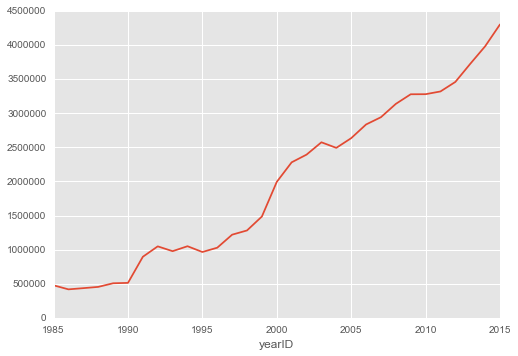

In [14]:
average_mean_salaries = salaries_table.groupby('yearID')['salary'].mean()
average_mean_salaries.plot()

There seems to be some kind of inflation. That could be from an inflation in the prices or from an just an inflation in the salaries of baseball players. This seems to mean that our findings, that most players experience a growth in salary may be influenced by the fact that all players experience a salary growth regardless, because of inflation. That also means that I can't use a qualitative analysis because salaries are likelly to increase regardless of awards.

As (https://discussions.udacity.com/t/testing-for-correlation-between-the-salaries-of-baseball-players-and-awards-won/185580)[george liu] pointed out it might be better to analyse different salaries globally in respect to time, in other words, compare the average salaries throught their carreers between players that won an award or not.

In this manner there are a few things to consider:

* The inflation
* The distribution of players that won awards by year
* The distribution of awards that each player won

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd788b98050>]], dtype=object)

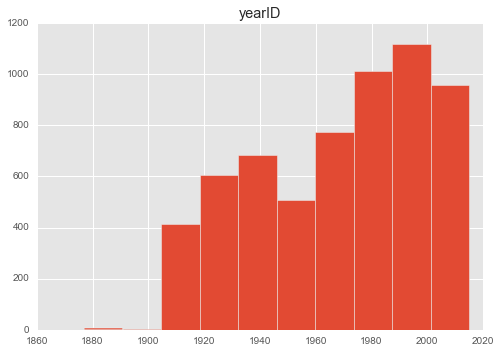

In [15]:
awards_table[['yearID']].hist()

So the number of players that received an award is greater in more recent years. But is the relative frequency also greater? In other words, is there a greater proportion of players that won an award in recent years? If there is then we probably can't use the average salary to compare players that won an award or not because we would be comparing, mostly players from different years and then inflation could influence our results, greatly.

So now we need to plot the relative frequencies of players that won an award against players that did not.

yearID  playerID 
1986    anderla02    2
        carltst01    2
        fostege01    2
        grosswa01    2
        johnto01     2
Name: playerID, dtype: int64


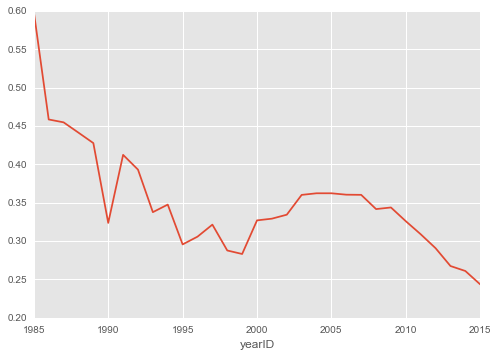

In [16]:
qty = salaries_table.groupby('yearID')['playerID'].value_counts()
#number of player salaries that appear each year
print qty[qty > 1].head()
#since the number of duplicates is relativelly small I can probably ignore it
winners = merged[merged.firstAward != np.NAN]
nonwinners = salaries_table[~salaries_table.playerID.isin(awards_table['playerID'])]

qty_winners = winners.groupby('yearID')['playerID'].size()
qty_nonwinners = nonwinners.groupby('yearID')['playerID'].size()
(qty_winners / qty_nonwinners).plot()

So although there are more awards being granted in more recent years, the probability that a player will receive an ward is smaller because there are also many more players competing for the awards.


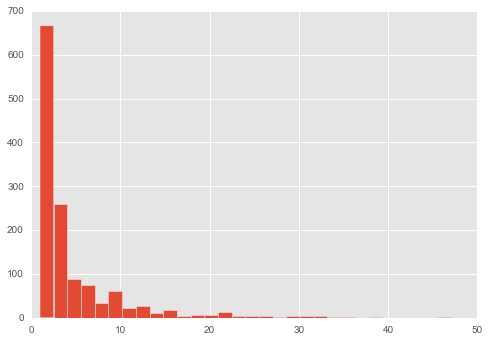

In [17]:
#Distribution of players that won an award
multi_awards = awards_table['playerID'].value_counts()
multi_awards.hist(bins=30)

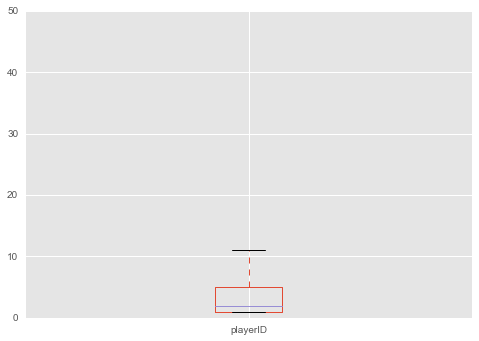

In [18]:
#Boxplot of the same distribution
multi_awards.plot.box()

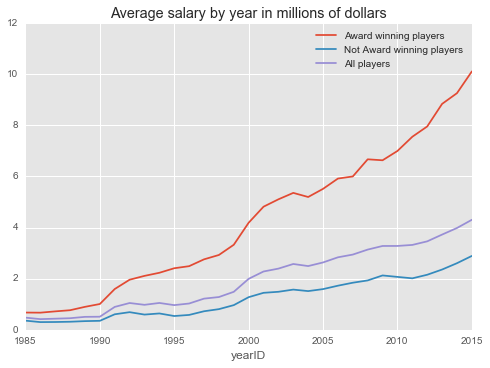

In [22]:
result = pd.DataFrame()
win = winners.groupby('yearID')['salary']
result['Award winning players'] = win.mean()
nwin = nonwinners.groupby('yearID')['salary']
result['Not Award winning players'] = nwin.mean()
result['All players'] = average_mean_salaries
result = result / 1000000
result.plot(title='Average salary by year in millions of dollars')

Although there seems to be some influence of inflation for salaries, it seems like the influence of having an award is much greater. In order to test that we are going to do a t test.

We wish to test if having an award is correlated to higher salaries throught a player carreer. We already know that it's the average for each year that players that receive an award on average gain more than players that don't but we actually want to test if that result is statistically significant for a certain alfa.

In order to do that we wish to do a t-test for correlation between salary and "award-winning-ness", for this test our dependent variable is salary and our independent variable is having an award. Before we are able to do the test we need to check wether our dataset can be analysed using a t-test, the assumptions used here are those provided by Laerd Statistics(https://statistics.laerd.com/spss-tutorials/independent-t-test-using-spss-statistics.php).


* - Assumption 1: Your dependent variable should be measured on a continuous scale or ordinal scale.

Salary is ordinal.

* - Assumption 2: Your independent variable should consist of two categorical, independent groups.

The groups are independent since a player either won an award or did not.

* - Assumption 3: You should have independence of observations, which means that there is no relationship between the observations in each group or between the groups themselves.

That is a trickier assumption since we don't know what goes in the mind of the person that chooses the salary of a player or the player that accepts to work for a certain salary. It's very possible that many non award winning players receiving a high salary could push the salary of award winning players up since the award winning player may not want to work for the same remuneration as for everyone else. In since payments are decided by contracts.

Because of that we choose calculate the t-score for each year to limit the influence of temporality on our analysis. It's important to notice that we are assuming that contracts cannot influence one another significantly in the same year.

* - Assumption 4: There should be no significant outliers.

TODO

* - Assumption 5: Your dependent variable should be approximately normally distributed for each group of the independent variable.
TODO
* - Assumption 6: There needs to be homogeneity of variances.
TODO




## Step Four - Share Your Findings
Once you have finished analyzing the data, create a report that shares the findings you found most interesting.


## Step Five - Review
Use the Project Rubric to review your project. If you are happy with your submission, then you're ready to submit your project. If you see room for improvement, keep working to improve your project.
